In [64]:
from region_detection import *
from commonfunctions import *

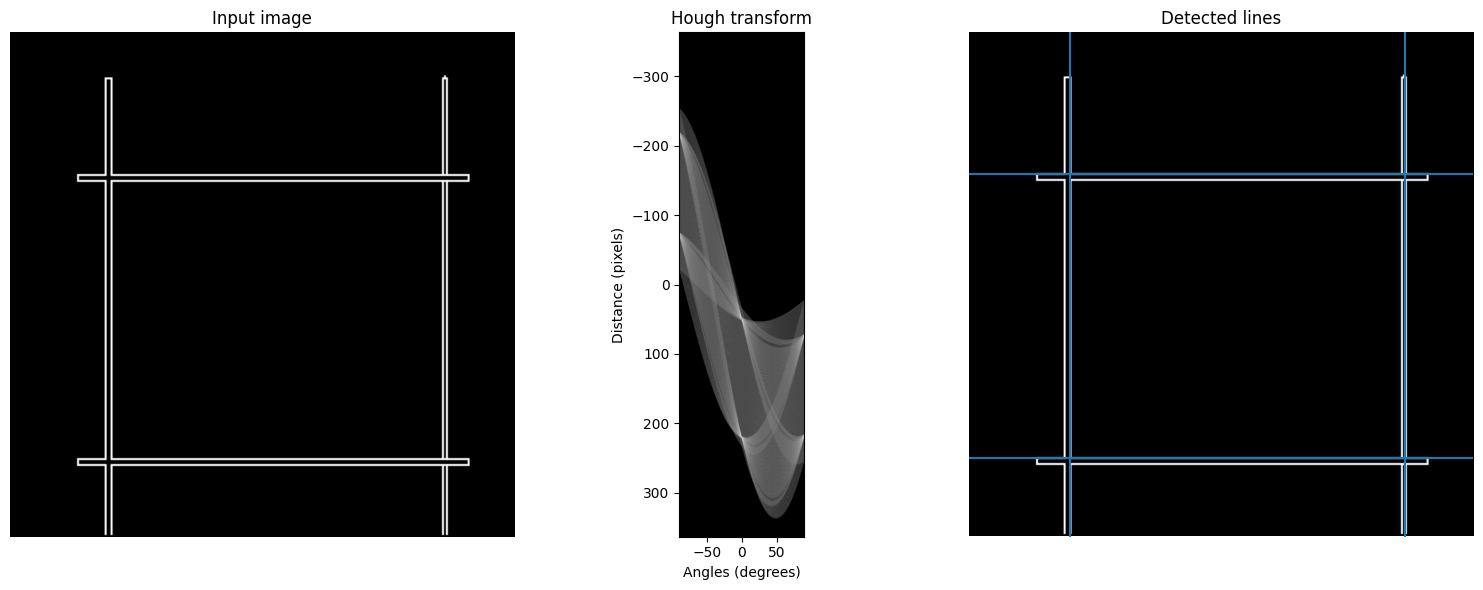

[(221.0, 72.0), (221.0, 216.0), (51.0, 72.0), (51.0, 216.0)]
72 216
51 221


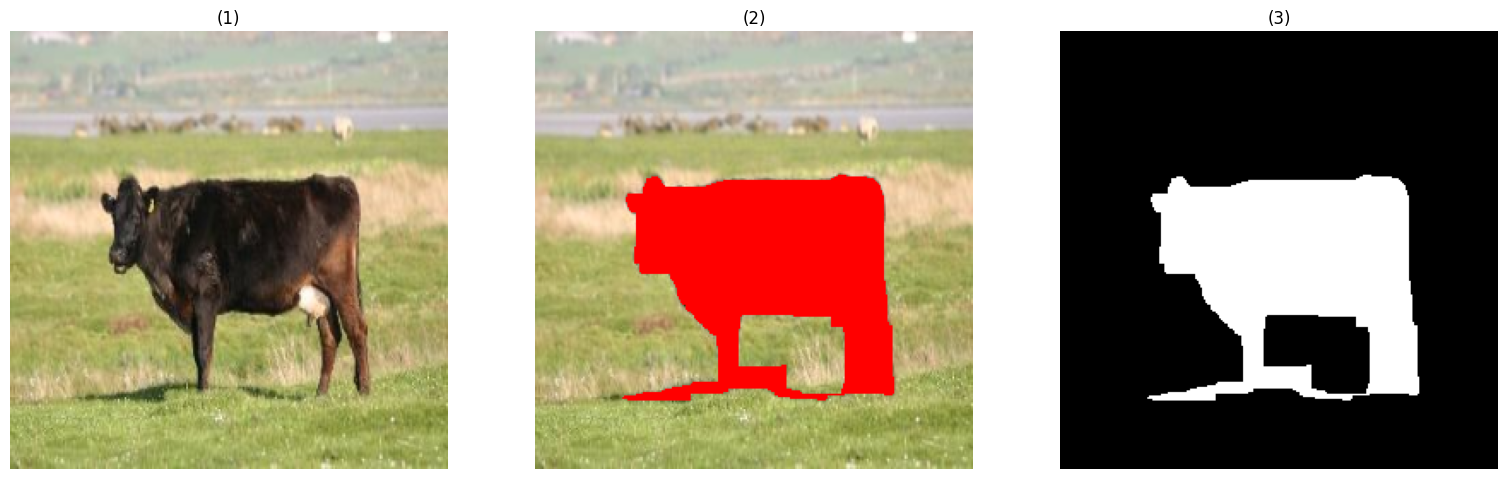

In [65]:
cow_select=io.imread('images-to-be-tested/cow_with_selection.png')
cow_orig=io.imread('images-to-be-tested/cow.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = rgba2rgb(cow_sel_resize)
cow_resized_orig = cv2.resize(cow_orig, target_img_size)


# # Create an instance of the RegionDetection class
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

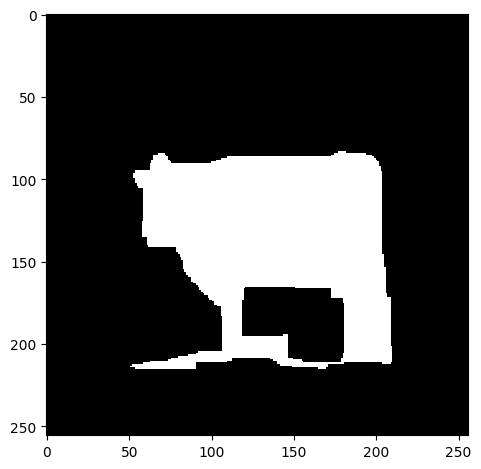

In [66]:
io.imshow(binary_mask_test)

In [67]:
def MSD(target_patch, exemplar_patch, M_bar):
    # if not np.isin(1,M_bar):
    #     return float('inf')

    # msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)/np.sum(M_bar)
    # return msd

    msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)
    return msd

def SMD (target_patch, exemplar_patch, binary_mask, M_bar):
    # if not np.isin(1,M_bar):
    #     return float('inf')

    # target_existing_avg= np.sum(M_bar * target_patch)/np.sum(M_bar)
    # exemplar_fill_avg = np.sum(binary_mask* exemplar_patch)/np.sum(binary_mask)
    # smd= (target_existing_avg-exemplar_fill_avg)**2
    # return smd 

    target_existing_avg= np.sum(M_bar * target_patch)
    exemplar_fill_avg = np.sum(binary_mask* exemplar_patch)
    smd= (target_existing_avg-exemplar_fill_avg)**2
    return smd 

def findBestsubPatch(target_patch, exemplar_patches, binary_mask, M_bar):
    best_patch=None
    min_combined_error= float('inf')
    for other_patch in exemplar_patches:
        current_error=MSD(target_patch,other_patch,M_bar)+ SMD(target_patch,other_patch,binary_mask,M_bar)
        if current_error < min_combined_error:
            best_patch = other_patch
    return best_patch

def findBestFullPatch(target_patches, exemplar_patches,binary_mask_patches, M_bar_patches):
    cp_target_patches = np.copy(target_patches)
    for i,target_patch in enumerate(target_patches):
        best_sub_patch=findBestsubPatch(target_patch,exemplar_patches,binary_mask_patches[i],M_bar_patches[i])
        cp_target_patches[i][binary_mask_patches[i] == 1] = best_sub_patch[binary_mask_patches[i] == 1]
    return cp_target_patches


In [76]:
def main(img,binary_mask, overlap=2):
    patch_size = 8
    img_in_patches= [img[i:i+patch_size,j:j+patch_size] for i in range(0,img.shape[0]-patch_size+1, overlap) for j in range(0,img.shape[1]-patch_size+1, overlap) ]
    full_binary_mask_patches = [binary_mask[i:i+patch_size,j:j+patch_size] for i in range(0,img.shape[0]-patch_size+1, overlap) for j in range(0,img.shape[1]-patch_size+1, overlap) ]
    #if the patch contains a single 1 then it's subset of the target patch so mark it with 1 in the bit map
    # bit_map=[ 1 if np.isin(1,full_binary_mask_patches[i]) else 0 for i in range(len(full_binary_mask_patches))]

    target_indices=[]
    exemplar_indices=[]
    binary_mask_patches= []
    target_patches=[]
    exemplar_patches=[]
    target_patch_counter=0
    patches_per_row = (img.shape[0] - patch_size) // overlap + 1
    patches_per_col = (img.shape[1] - patch_size) // overlap + 1
    for i, binary_mask_patch in enumerate(full_binary_mask_patches):

        start_row = (i // patches_per_row) * overlap
        start_col = (i % patches_per_row) * overlap
        if np.isin(1,binary_mask_patch):
            # This means that it is a target patch
            target_indices.append((target_patch_counter,start_row,start_col))
            binary_mask_patches.append(full_binary_mask_patches[i])
            target_patches.append(img_in_patches[i])
            target_patch_counter+=1
            # binary_mask_patches.append(binary_mask[start_row:start_row+patch_size])

        else:
            exemplar_indices.append((i, start_row, start_col))
            exemplar_patches.append(img_in_patches[i])


    # M_bar_patches=[np.where((binary_mask_patches[i]==0)|(binary_mask_patches[i]==1), binary_mask_patches[i]^1, binary_mask_patches) for i in range(len(binary_mask_patches))]
    M_bar_patches=[1-binary_mask_patches[i] for i in range(len(binary_mask_patches))]
    #TO-DO: call implemented functions
    new_target_patches=findBestFullPatch(target_patches,exemplar_patches,binary_mask_patches,M_bar_patches)

    new_img= np.copy(img)
    for target_index, start_row, start_col in target_indices:
        new_img[start_row: start_row+patch_size, start_col:start_col+patch_size]=new_target_patches[target_index]
    
    return new_img

    # list of tuples (i,start_row,start_col)
    '''
    for target_index, start_row, start_col in target_indices:
        img[start_row:start_row+patch_size , start_col: start_col+patch_size]=cp_target_patches[target_index]
        start_row = (i // (img.shape[0] // patch_size)) * patch_size
        start_col = (i % (img.shape[1] // patch_size)) * patch_size
    
    '''




In [69]:
binary_mask_test=binary_mask_test[:,:,0]
grayLevelImg = (rgb2gray(cow_resized_orig)*255).astype('uint8')

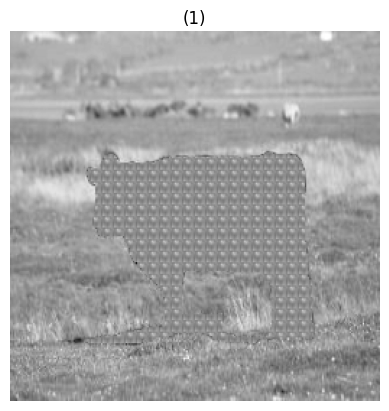

In [70]:
newImg= main(grayLevelImg,binary_mask_test, overlap=8)
show_images([newImg])

found


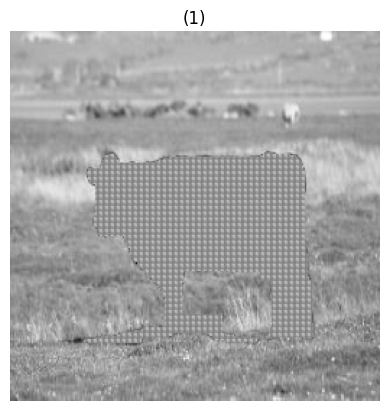

In [71]:
newImgOverlap2= main(grayLevelImg,binary_mask_test, overlap=4)
show_images([newImgOverlap2])

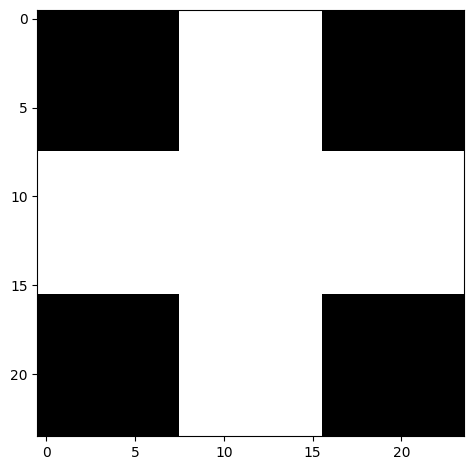

In [77]:
img1=np.zeros((24,24))
img1=np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],

    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],


    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],

])

img1=(img1*255).astype('uint8')
img1=255-img1
io.imshow(img1)

[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1

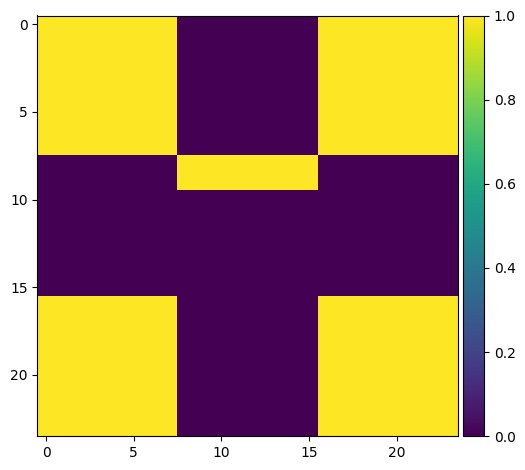

In [78]:
img2=np.copy(img1)
img2=(img2*255).astype('uint8')
print(img2)
img3=1-img2
img3[8:10,8:16]=1
print(img3)
io.imshow(img3)


binary_mask_img2=np.zeros((24,24))
binary_mask_img2[8:12,8:16]=1

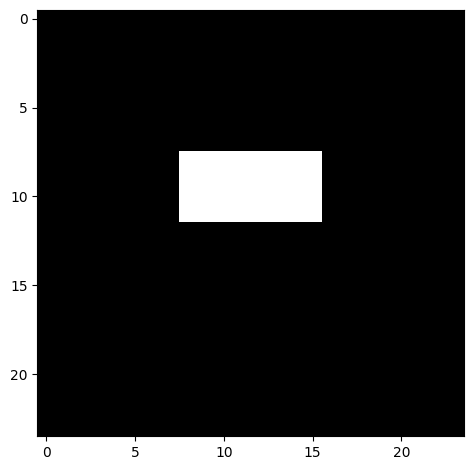

In [79]:
io.imshow(binary_mask_img2)

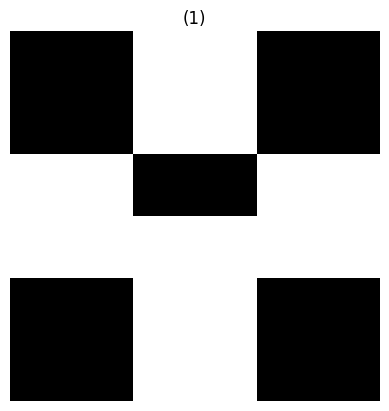

In [80]:
newImg2= main(img2,binary_mask_img2,overlap=8)
show_images([newImg2])